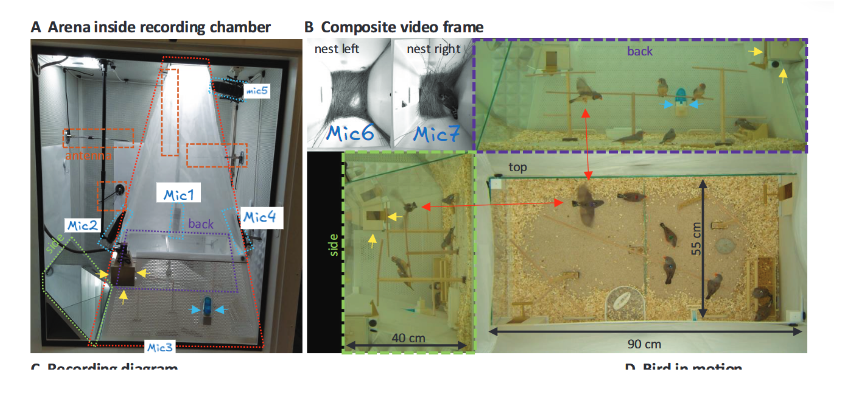

In [ ]:
## this script exemplifies how BirdPark data is loaded into python and prints file info
## author:  Linus Rüttimann
## version: 2023-01-01 
import h5py
import pandas as pd

# hdf5 file name
h5fn = r"C:\Users\Admin\Documents\Akseli\Code\EthoGraph\data\copExpBP08\BP_2021-05-25_08-12-51_655154_0380000.h5"
seg_path = r"C:\Users\Admin\Documents\Akseli\Code\EthoGraph\data\copExpBP08\segments.h5"

# get file object
f1 = h5py.File(h5fn, 'r')

# read recording info
recInfo = f1['/recInfo'].attrs #is a dictionary of attributes

print('----recInfo:----')
for key in recInfo:
    print(key, ' : ', recInfo[key])

#read file info
fileInfo = f1['/fileInfo'].attrs #is a dictionary of attributes

print(' ')
print('----fileInfo:----')
for key in fileInfo:
    print(key, ' : ', fileInfo[key])

# show radio channel info
vNames = ("radioChNames", "radioChSenderColors", "radioChSenderIds", "radioChCenterFrqs_Hz", "radioChBirdRadioIds", "radioChSenderDescs")
radioChInfo = pd.DataFrame({k:recInfo[k] for k in vNames})

print(' ')
print('----radioCh info as a table:----')
print(radioChInfo)

# show daq channel info
daqChInfo = pd.DataFrame({k:recInfo[k] for k in ("daqChNames", "daqChDescs")})

print(' ')
print('----daqCh info as a table:----')
print(radioChInfo)
print(daqChInfo)

# example how to convert string timestamps to pandas datetime object
dateStrFormat = '%Y-%m-%dT%H:%M:%S.%f%z'
t = pd.to_datetime(recInfo['recStartTime'], format=dateStrFormat)

# read main data
radioSignals = f1['/radioSignals'][()] # accelerometer transmitter device signals (one row per channel)
daqSignals = f1['/daqSignals'][()] # microphone signals (one row per channel)

print(' ')
print('----main signals:----')
print(f'radioSignals:\tshape={radioSignals.shape}, dtype={radioSignals.dtype}')
print(f'daqSignals:\tshape={daqSignals.shape}, dtype={daqSignals.dtype}')

# auxFramesSignals
auxFrameSignals = f1['/auxFrameSignals']

print(' ')
print('----auxFrameSignals:----')
for key in auxFrameSignals:
    print(f'{key}:\tshape={auxFrameSignals[key].shape}, dtype={auxFrameSignals[key].dtype}')


# radioFrameSignals
radioFrameSignals = f1['/radioFrameSignals']

print(' ')
print('----radioFrameSignals:----')
for key in radioFrameSignals:
    print(f'{key}:\tshape={radioFrameSignals[key].shape}, dtype={radioFrameSignals[key].dtype}')

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\Admin\Documents\Akseli\Code\EthoGraph\data\copExpBP08\BP_2021-05-25_08-12-51_655154_0380000.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [61]:
seg_path = r"C:\Users\aksel\Documents\Code\EthoGraph\data\copExpBP08\segments.h5"

# get file object
f1 = h5py.File(seg_path, 'r')
f1["segments"]

<HDF5 dataset "segments": shape (7553,), type "|V136">

In [ ]:
import xarray as xr
import numpy as np
from audioio import write_audio
from ethograph.features.audio_features import get_envelope
from ethograph import minimal_basics, set_media_attrs
from ethograph.features.mov_features import extract_video_motion


frameRate_Hz = 47.6837158203125
sampleRate_Hz = 24414.0625 # audio and accelerometer

# Microphone locations
mic_locations = [
    "mic 1: rear stage wall",
    "mic 2: left stage wall", 
    "mic 3: front stage wall",
    "mic 4: right stage wall",
    "mic 5: ceiling of isolation box",
    "mic 6: inside Nest1 (left)",
    "mic 7: inside Nest2 (right)"
]


path = r'C:\\Users\\aksel\\Documents\\Code\\EthoGraph\\data\\copExpBP08\\audio_7_channels.wav'

write_audio(path, daqSignals.T, sampleRate_Hz)

envelope, _ = get_envelope(path, 24000, 100)


time_coords = np.arange(radioSignals.shape[1]) / sampleRate_Hz

video_path = r'C:\\Users\\aksel\\Documents\\Code\\EthoGraph\\data\\copExpBP08\\video.mp4'


ds = xr.Dataset(
        data_vars={
            "vibration": xr.DataArray(
                radioSignals.T,
                dims=["time", "individuals"],
            ),
            "envelope": xr.DataArray(
                envelope,
                dims=["time_env", "channels"],
            ),
        },
        coords={
            "time": time_coords,
            "time_env": np.arange(envelope.shape[0]) / 1000,
            "individuals": ["male (red radio)", "female (yellow radio)"],
        },
        attrs={
            "fps": frameRate_Hz,
            "audio_sr": sampleRate_Hz
            
        }
    )

ds["video_motion"] = extract_video_motion(video_path, fps=frameRate_Hz, time_coord_name="time_video")


ds = set_media_attrs(
        ds,
        cameras=["video.mp4"],
        mics=["audio.wav"])

dt = minimal_basics(ds)

dt.to_netcdf(r'C:\\Users\\aksel\\Documents\\Code\\EthoGraph\\data\\copExpBP08\\birdpark_accelerometer.nc',)

2026-01-25 22:50:21.431 | WARNING  | xarray.core.utils:emit_user_level_warning:1268 - C:\Users\aksel\Documents\Code\EthoGraph\ethograph\utils\io.py:345: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  np.zeros((ds.dims["time"], ds.dims["individuals"])),



Extracted type_vars_dict: {'individuals': array(['male (red radio)', 'female (yellow radio)'], dtype='<U21'), 'cameras': array(['cam1'], dtype='<U4'), 'mics': array(['mic1'], dtype='<U4'), 'features': ['vibration (accelerometer)', 'envelope'], 'trial_conditions': []}


In [ ]:
import noisereduce as nr
import audioio as aio
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation

# pip install librosa noisereduce git+https://github.com/timsainb/vocalization-segmentation.git

def process_audio(path: str, denoise: bool = True):
    audio, sr = aio.load_audio(path)
    

    
    if denoise:
        audio = nr.reduce_noise(y=audio[:, 0], sr=sr, stationary=True)

    
    results = dynamic_threshold_segmentation(
        vocalization=audio,
        rate=sr,
        hop_length_ms=5,  # 5x faster
        min_level_db=-70,
        min_syllable_length_s=0.02,
    )
    
    return audio, sr, results['onsets'], results['offsets']


data, sr, onsets, offsets = process_audio(path)
data

memmap([-7.04744339e-20, -8.42408706e-20, -7.63920407e-20, ...,
         1.21028910e-04,  1.01533617e-04,  8.63906672e-05],
       shape=(10240000,))

In [73]:
len(onsets)

996

In [ ]:
dt.itrial(0).audio_sr

24414.0625

In [ ]:
dt.itrial(0).labels.values.shape

(10240000, 2)

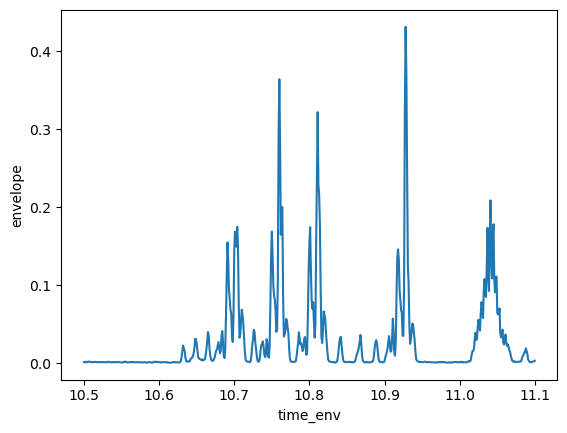

In [ ]:


dt.itrial(0).envelope.isel(channels=0).sel(time_env=slice(10.5, 11.1)).plot()

In [ ]:
from ethograph.features.audio_features import get_envelope




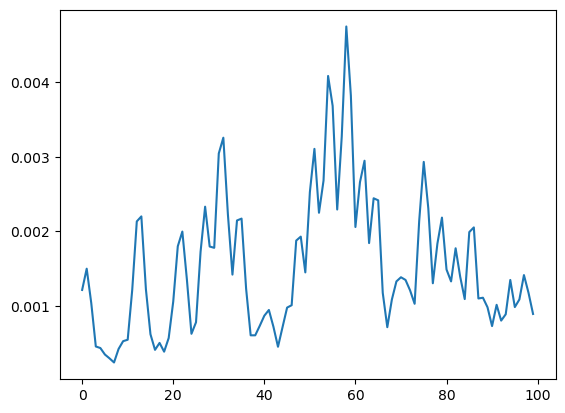

In [ ]:
import matplotlib.pyplot as plt

plt.plot(envelope[900:1000, 0])


In [ ]:
1119 + frameRate_Hz

1166.6837158203125

In [ ]:
# Downsample the data by a factor (e.g., 10) and plot
downsample_factor = 10
acc_downsampled = acc.isel(time=slice(None, None, downsample_factor))

fig = plt.figure(figsize=(10,5))
acc_downsampled.sel(time=slice(170, 170.25)).isel(individuals=0).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'isel'

In [ ]:
import pandas as pd

# Read the HDF5 file as a table
df = pd.DataFrame(f1["segments"][()])
df


,filename,onset,offset,channel,unsure,bird,transmitter,firstMic,nOverlapSyl,chType,chNum,birdNum,trNum,firstMicNum,crosstalk,expInstanceId,segType
0,b'copExpBP08/BP_2021-05-25_08-12-51_655154_038...,17376.0,19008.0,b'Mic1',0.0,b'',b'',b'',1.0,b'daq',1.0,NaN,NaN,NaN,NaN,b'copExpBP08',b'microphone-based'
1,b'copExpBP08/BP_2021-05-25_08-12-51_655154_038...,17376.0,19008.0,b'',NaN,b'b15y3_f',b'b15y3_f',b'Mic1',0.0,b'cons',NaN,2.0,2.0,1.0,NaN,b'copExpBP08',b'consolidated'
2,b'copExpBP08/BP_2021-05-25_08-12-51_655154_038...,17472.0,18912.0,b'b15y3_f',0.0,b'',b'',b'',1.0,b'radio',2.0,NaN,NaN,NaN,0.0,b'copExpBP08',b'transmitter-based'
3,b'copExpBP08/BP_2021-05-25_08-12-51_655154_038...,132000.0,133632.0,b'Mic1',0.0,b'',b'',b'',1.0,b'daq',1.0,NaN,NaN,NaN,NaN,b'copExpBP08',b'microphone-based'
4,b'copExpBP08/BP_2021-05-25_08-12-51_655154_038...,132000.0,133632.0,b'b15y3_f',0.0,b'',b'',b'',1.0,b'radio',2.0,NaN,NaN,NaN,0.0,b'copExpBP08',b'transmitter-based'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7548,b'juvExpBP03/BP_2022-11-29_08-19-52_348499_030...,1454640.0,1457229.0,b'',0.0,b'JU3a_jm',b'JU3a_jm',b'Mic1',0.0,b'cons',NaN,7.0,7.0,1.0,NaN,b'juvExpBP03',b'consolidated'
7549,b'juvExpBP03/BP_2022-11-29_08-19-52_348499_030...,1459767.0,1462600.0,b'',0.0,b'JU3a_jm',b'JU3a_jm',b'Mic1',0.0,b'cons',NaN,7.0,7.0,1.0,NaN,b'juvExpBP03',b'consolidated'
7550,b'juvExpBP03/BP_2022-11-29_08-19-52_348499_030...,1463160.0,1472659.0,b'',0.0,b'JU3a_jm',b'JU3a_jm',b'Mic1',0.0,b'cons',NaN,7.0,7.0,1.0,NaN,b'juvExpBP03',b'consolidated'
7551,b'juvExpBP03/BP_2022-11-29_08-19-52_348499_030...,1415265.0,1416092.0,b'Mic1',0.0,b'',b'',b'',NaN,b'daq',1.0,NaN,NaN,1.0,NaN,b'juvExpBP03',b'microphone-based'


In [ ]:
# Create downsampled version of the dataset (factor of 100)
# This uses min-max envelope to preserve peaks while reducing size

import xarray as xr
import numpy as np
from pathlib import Path

# Load original dataset
nc_path = Path(r'C:\Users\aksel\Documents\Code\EthoGraph\data\copExpBP08\birdpark_accelerometer.nc')
ds = xr.open_dataset(nc_path)

downsample_factor = 100
original_sr = ds.attrs.get('audio_sr', 24414.0625)
new_sr = original_sr / downsample_factor

# Get the data variable name
data_var = 'vibration (accelerometer)'
data = ds[data_var].values  # shape: (time, individuals)

n_time, n_individuals = data.shape
n_segments = n_time // downsample_factor

# Downsample using min-max envelope (preserves peaks)
usable_len = n_segments * downsample_factor
data_trimmed = data[:usable_len]

# Reshape to (n_segments, downsample_factor, n_individuals)
reshaped = data_trimmed.reshape(n_segments, downsample_factor, n_individuals)

# Compute min and max per segment
mins = reshaped.min(axis=1)
maxs = reshaped.max(axis=1)

# Interleave min/max: shape becomes (n_segments*2, n_individuals)
downsampled = np.empty((n_segments * 2, n_individuals), dtype=data.dtype)
downsampled[0::2] = mins
downsampled[1::2] = maxs

# Create new time coordinates (interleaved for min/max)
original_time = ds.time.values[:usable_len]
time_downsampled = original_time[::downsample_factor]
time_interleaved = np.repeat(time_downsampled, 2)
# Offset max times slightly for proper envelope display
dt = (original_time[-1] - original_time[0]) / len(original_time)
time_interleaved[1::2] += dt * downsample_factor / 2

# Create new dataset
ds_downsampled = xr.Dataset(
    data_vars={
        data_var: xr.DataArray(
            downsampled,
            dims=["time", "individuals"],
        ),
    },
    coords={
        "time": time_interleaved,
        "individuals": ds.individuals.values,
    },
    attrs={
        **ds.attrs,
        "audio_sr": new_sr,  # Update sample rate
        "original_sr": original_sr,
        "downsample_factor": downsample_factor,
        "downsample_method": "minmax_envelope",
    }
)

# Copy labels if they exist (also downsampled)
if 'labels' in ds:
    labels = ds['labels'].values[:usable_len]
    labels_reshaped = labels.reshape(n_segments, downsample_factor, n_individuals)
    # For labels, take the max (any label present in segment)
    labels_down = labels_reshaped.max(axis=1)
    labels_interleaved = np.repeat(labels_down, 2, axis=0)
    ds_downsampled['labels'] = xr.DataArray(
        labels_interleaved,
        dims=["time", "individuals"],
    )

# Save downsampled version
output_path = nc_path.parent / f'{nc_path.stem}_downsampled_{downsample_factor}x.nc'
ds_downsampled.to_netcdf(output_path)

print(f"Original: {n_time:,} samples at {original_sr:.1f} Hz")
print(f"Downsampled: {len(time_interleaved):,} samples at {new_sr:.1f} Hz")
print(f"Saved to: {output_path}")